# Example: Feature engineering

**Motivation**:
* Garbage in $=$ garbage out (GIGO).
* Machine Learning methods are limited, cannot make gold from lead
* Domain knowledge and random or exhaustive feature engineering can unlock patterns hidden from models.

**Creating features**:

Should expand the feature space, preferrably in a non-linear fashion.
Simple linear combinations typically do not add anything new.
* Polynomial features from interactions (products / quotients).

Non-linear functions of single features or feature combinations
Transformations:
* log
* Box-Cox
    
Feature combinations/crossing
* Combinations that cannot be represented by the linear system, e.g. ReLU and friends.

*Feature bucketing*
* Create major categories from continuous or multi class data.

*Feature templates*
* Implicit generation of new features in a model, or group of features all computed in a similar way.
    * Length greater than ...
    * Last three characters equals ...
    * Contains character ...

*Feature hashing*
* Use hashing algorithms to create vectors/matrices from complicated predictors.
* E.g. dictionary type terms where the vocabulary may grow.



In [1]:
import numpy as np
import pandas as pd

import seaborn as sns
import missingno as ms
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
raw_data = pd.read_csv(
    './datasets/process_log.csv', sep=',', index_col=0
)
raw_data.head()

,process_start,boiling_stop,stretch_stop,floppiness,flostard,flober,lard,flubberiness
0,2018-06-29 01:57:00,2018-06-29 04:06:00,2018-06-29 04:33:00,high,0.726494,20.667655,19438.097842,596934.441785
1,2018-06-29 03:44:00,2018-06-29 05:53:00,2018-06-29 06:16:00,low,0.845524,19.199460,20082.661675,647730.495391
2,2018-06-29 05:31:00,2018-06-29 07:34:00,2018-06-29 07:59:00,low,0.028887,20.399001,19184.709928,537041.204320
3,2018-06-29 05:49:00,2018-06-29 07:49:00,2018-06-29 08:10:00,medium,0.188165,20.363044,18524.828633,588746.939774
4,2018-06-29 07:04:00,2018-06-29 09:05:00,2018-06-29 09:34:00,low,1.156062,21.362930,21568.106683,542085.676371


Raw materials
-  flostard
-  flüber
-  lard

Process attributes
-  floppiness
-  process start
-  boiling stop
-  stretching stop

Response
-  flubberiness


## Exploration 

In [3]:
raw_data.dtypes

process_start     object
boiling_stop      object
stretch_stop      object
floppiness        object
flostard         float64
flober           float64
lard             float64
flubberiness     float64
dtype: object

In [4]:
raw_data.describe()

,flostard,flober,lard,flubberiness
count,987.000000,987.000000,987.000000,987.000000
mean,0.993358,20.049308,20016.724590,606852.519863
std,1.013302,1.011363,1004.410839,60565.664762
min,0.000442,16.498978,16650.781949,359531.427988
25%,0.302290,19.387500,19352.264961,568901.553551
50%,0.672968,20.004076,20006.250787,608196.996310
75%,1.330506,20.743244,20702.726846,647757.356231
max,9.837434,23.229651,22980.245305,787358.208602


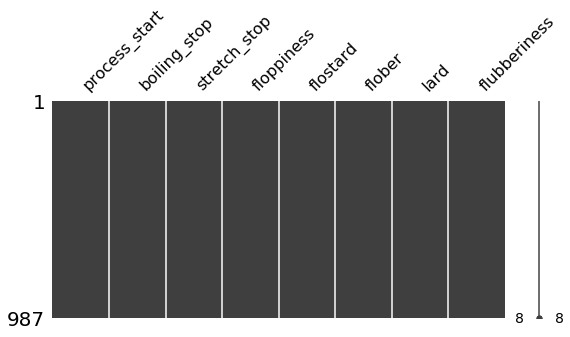

In [5]:
ms.matrix(raw_data, figsize=(9, 4));

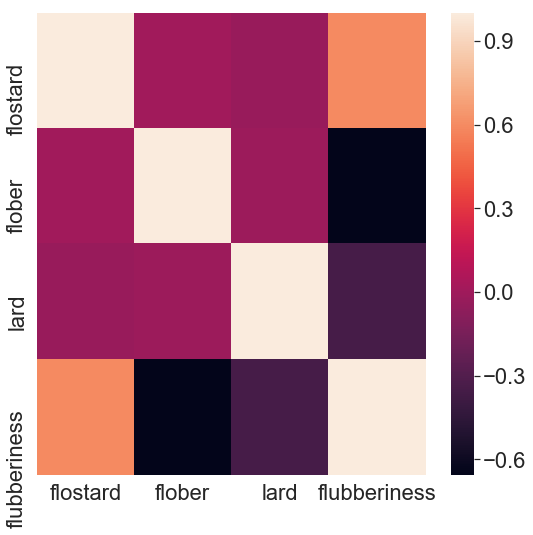

In [6]:
plt.figure(figsize=(8, 8))
sns.set(font_scale=2)
sns.heatmap(raw_data.corr())
plt.tight_layout()

<Figure size 576x576 with 0 Axes>

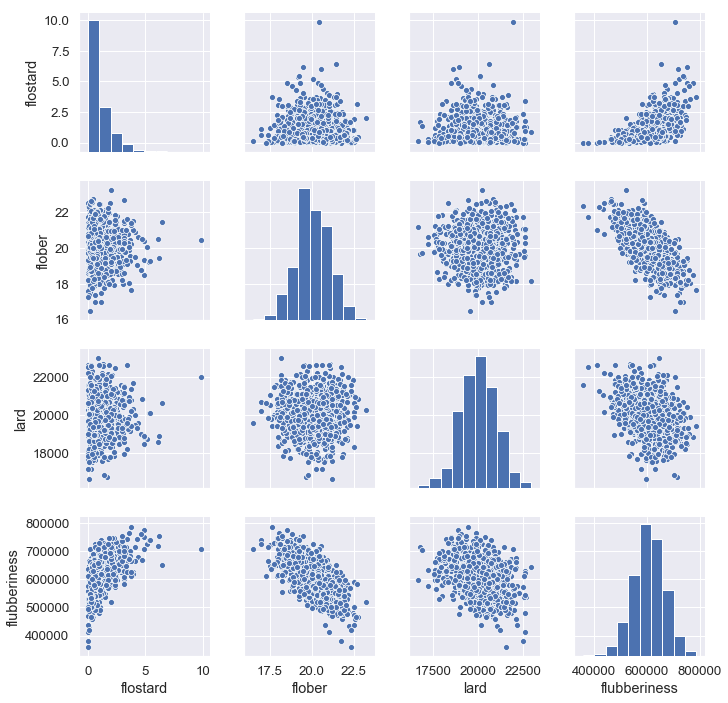

In [7]:
plt.figure(figsize=(8, 8));
sns.set(font_scale=1.2);
sns.pairplot(raw_data);

**Observations:**
* Apply $\log$ transform to *flostard*.

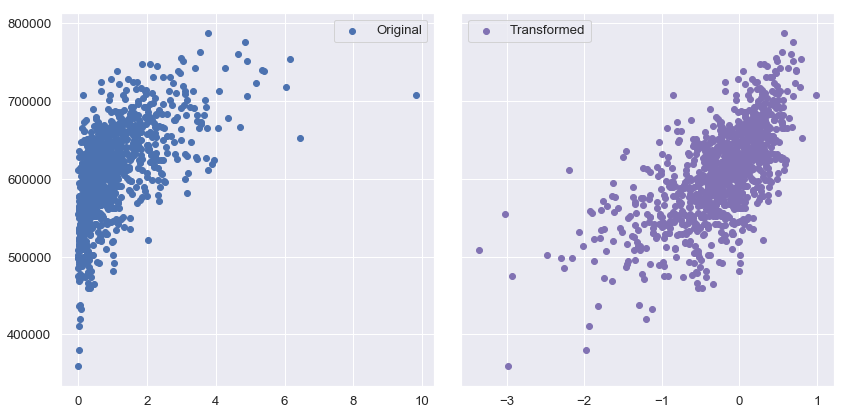

In [8]:
fig, axes = plt.subplots(
    ncols=2, figsize=(12, 6), sharey=True
)
axes[0].scatter(
    raw_data.flostard, raw_data.flubberiness, 
    label='Original', c='b'
)
axes[0].legend(loc='best')
axes[1].scatter(
    np.log10(raw_data.flostard), raw_data.flubberiness,
    label='Transformed', c='m'
)
axes[1].legend(loc='best')
plt.tight_layout()

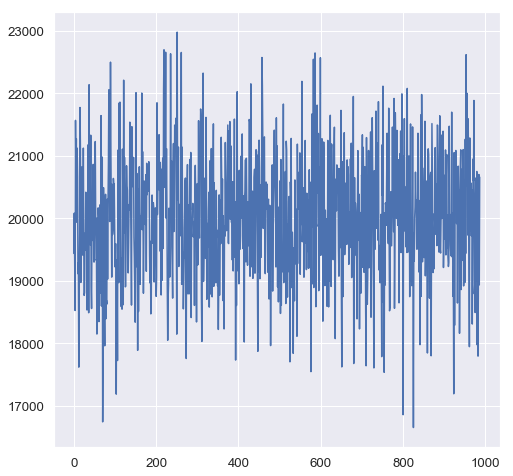

In [9]:
plt.figure(figsize=(8, 8))
plt.plot(raw_data.lard);

## Pre-processing

In [10]:
prep_data = raw_data.copy()

Encoding ordinal categorical feature

In [11]:
scale_mapper = {
    'low': 1.0, 'medium': 2.0, 'high': 3.0
}
prep_data['floppiness'].replace(scale_mapper, inplace=True)

Encoding time series data

In [12]:
prep_data.process_start = prep_data.process_start.astype('datetime64[m]')
prep_data.boiling_stop = prep_data.boiling_stop.astype('datetime64[m]')
prep_data.stretch_stop = prep_data.stretch_stop.astype('datetime64[m]')
prep_data.dtypes

process_start    datetime64[ns]
boiling_stop     datetime64[ns]
stretch_stop     datetime64[ns]
floppiness              float64
flostard                float64
flober                  float64
lard                    float64
flubberiness            float64
dtype: object

## Feature engineering

Number of seconds from process start to shut down at process step.

In [13]:
boiling_duration = prep_data.boiling_stop - prep_data.process_start
prep_data['boiling_duration'] = boiling_duration.dt.total_seconds()

stretch_duration = prep_data.stretch_stop - prep_data.process_start
prep_data['stretch_duration'] = stretch_duration.dt.total_seconds()

In [14]:
prep_data.describe()

,floppiness,flostard,flober,lard,flubberiness,boiling_duration,stretch_duration
count,987.000000,987.000000,987.000000,987.000000,987.000000,987.000000,987.000000
mean,2.018237,0.993358,20.049308,20016.724590,606852.519863,7472.279635,8938.480243
std,0.820424,1.013302,1.011363,1004.410839,60565.664762,170.235402,243.281572
min,1.000000,0.000442,16.498978,16650.781949,359531.427988,7200.000000,8400.000000
25%,1.000000,0.302290,19.387500,19352.264961,568901.553551,7320.000000,8760.000000
50%,2.000000,0.672968,20.004076,20006.250787,608196.996310,7440.000000,8940.000000
75%,3.000000,1.330506,20.743244,20702.726846,647757.356231,7620.000000,9120.000000
max,3.000000,9.837434,23.229651,22980.245305,787358.208602,7740.000000,9480.000000


Note that each process step duration $<$ day. Splitting up process start

In [15]:
prep_data['months'] = prep_data.process_start.dt.month
prep_data['days'] = prep_data.process_start.dt.day
prep_data['hours'] = prep_data.process_start.dt.hour
prep_data['minutes'] = prep_data.process_start.dt.minute

Merging hours and minutes of day

In [16]:
prep_data['time_of_day'] = prep_data.hours + prep_data.minutes / 60.0

Merging day and month of year

In [17]:
days_in_months = {
    6: 31,
    7: 30,
    8: 31,
    9: 30
}
prep_data['days_in_months'] = prep_data['months'].replace(days_in_months)
prep_data['time_of_year'] = prep_data.months + (prep_data.days / prep_data.days_in_months)

Encoding process start as cyclic event

In [18]:
prep_data['time_of_day_sin'] = np.sin(2 * np.pi * prep_data.time_of_day / 24)
prep_data['time_of_day_cos'] = np.cos(2 * np.pi * prep_data.time_of_day / 24)

prep_data['time_of_year_sin'] = np.sin(2 * np.pi * prep_data.time_of_year / 12)
prep_data['time_of_year_cos'] = np.cos(2 * np.pi * prep_data.time_of_year / 12)

Exploring the cyclic nature of the process

In [19]:
def kmeansshow(n_clusters, X):

    from sklearn import cluster

    kmeans = cluster.KMeans(n_clusters=n_clusters)
    kmeans.fit(X)

    labels, centroids = kmeans.labels_, kmeans.cluster_centers_
    for cluster in range(n_clusters):
        # select only data observations with cluster label == i
        ds = X[np.where(labels==cluster)]
        # plot the data observations
        plt.plot(ds[:, 0], ds[:, 1], 'o')
        # plot the centroids
        lines = plt.plot(centroids[cluster, 0], centroids[cluster, 1], 'kx')
        # make the centroid x's bigger
        plt.setp(lines, ms=15.0)
        plt.setp(lines, mew=2.0)

    return centroids

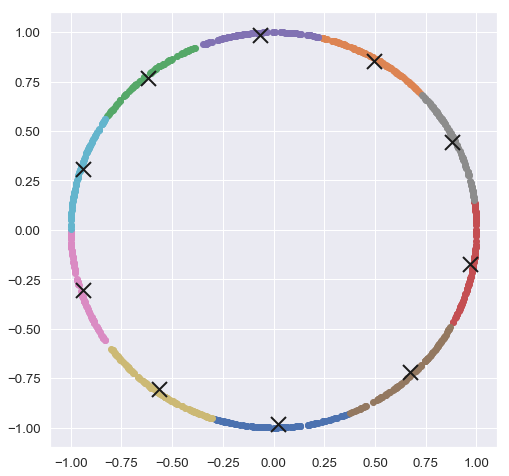

In [20]:
plt.figure(figsize=(8, 8))
centroids = kmeansshow(
    10, prep_data.loc[:, ['time_of_day_sin', 'time_of_day_cos']].values
)

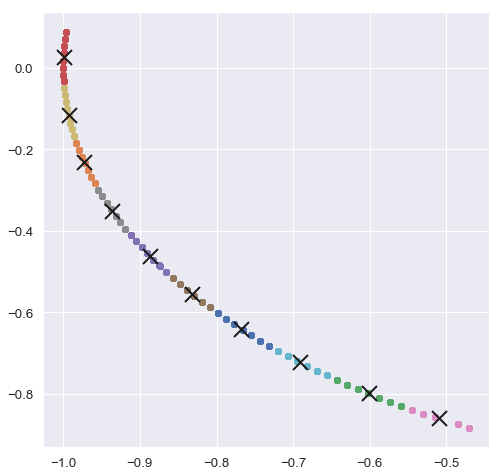

In [21]:
plt.figure(figsize=(8, 8))
centroids = kmeansshow(
    10, prep_data.loc[:, ['time_of_year_sin', 'time_of_year_cos']].values
)

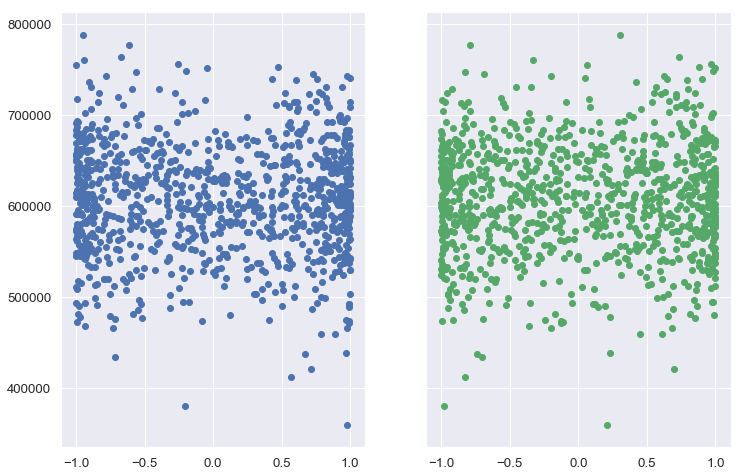

In [22]:
fig, axes = plt.subplots(
    nrows=1, ncols=2, figsize=(12, 8), sharey=True
)
axes[0].scatter(
    prep_data.time_of_day_sin, 
    prep_data.flubberiness,
    c='b'
)
axes[1].scatter(
    prep_data.time_of_day_cos, prep_data.flubberiness,
    c='g'
)

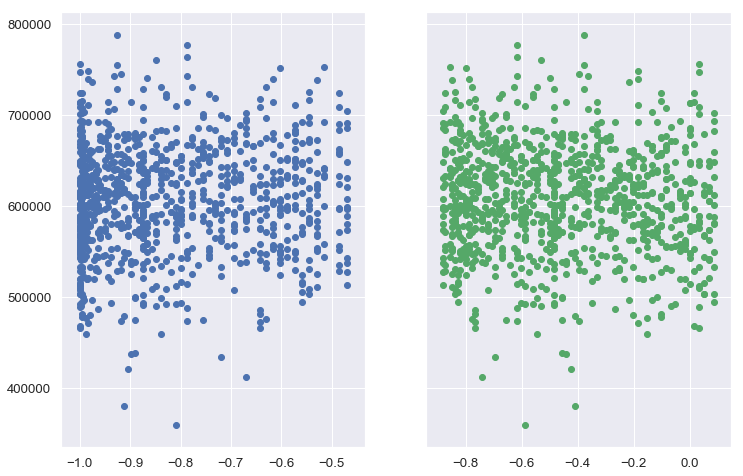

In [23]:
fig, axes = plt.subplots(
    nrows=1, ncols=2, figsize=(12, 8), sharey=True
)
axes[0].scatter(
    prep_data.time_of_year_sin, 
    prep_data.flubberiness,
    c='b'
)
axes[1].scatter(
    prep_data.time_of_year_cos, prep_data.flubberiness,
    c='g'
)

In [24]:
prep_data.drop(
    [
        'process_start', 'boiling_stop', 'stretch_stop',
        'months', 'days', 'hours', 'minutes', 'days_in_months',
        #'time_of_day', 'time_of_year'
    ],
    axis=1, inplace=True
)

### Transformations

The Rectified Linear Units (ReLU) function
$$
f(x) = x^+ = \max(0, x)
$$
A non-linear feature transformation. Note discontinuity at zero. 

The Leaky ReLU function
$$
f(x) = \max(\alpha x, x)
$$
where $\alpha \in (0, 1)$. 

The Exponential Linear Units (ELU) function
$$
f(x) = \max(\alpha(e^x - 1), x)
$$
where $0 < \alpha$.

In [25]:
def ReLU(feature):
    """A Rectified Linear Units feature transformation."""
    
    _feat = np.copy(feature)
    _feat[_feat < 0] = 0
    
    return _feat
    
    
def LeakyReLU(feature, alpha=1):
    """A leaky Rectified Linear Units feature transformation
    with soft truncation of the feature."""
    
    _feat = np.copy(feature)
    _feat[_feat < 0] = alpha * _feat[_feat < 0]

    return _feat

    
def ELU(feature, alpha=1):
    """The Explonential Linear Units faeture 
    transformation"""
    
    _feat = np.copy(feature)
    _feat[_feat < 0] = alpha * (np.exp(_feat[_feat < 0]) - 1)
    
    return _feat    

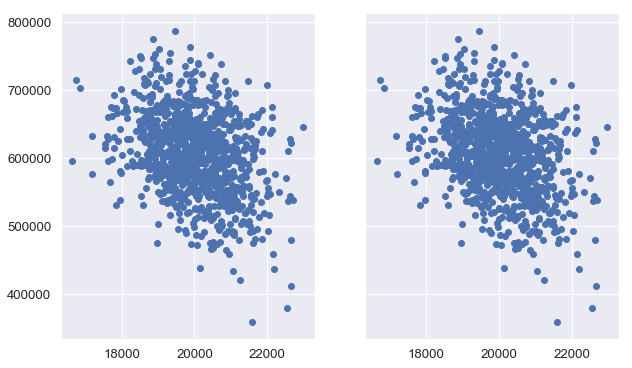

In [26]:
fig, axes = plt.subplots(
    nrows=1, ncols=2, figsize=(10, 6), sharey=True
)
axes[0].scatter(
   prep_data.lard, prep_data.flubberiness
)
axes[1].scatter(
   ELU(prep_data.lard), prep_data.flubberiness
)

## Predictions

In [27]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import learning_curve
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

In [28]:
SEED = 0
THRESH = 10e-8

target = prep_data.flubberiness.values[:, np.newaxis]
train = prep_data.loc[:, prep_data.columns != 'flubberiness'].values

In [29]:
model = LinearRegression(
    fit_intercept=True, normalize=False, copy_X=True, n_jobs=1
)

In [30]:
train_sizes, train_scores, test_scores = learning_curve(
    model, train, target, cv=10, n_jobs=1, train_sizes=np.linspace(.1, 1, 7)
)

/Users/severinlangberg/anaconda/lib/python3.6/site-packages/sklearn/linear_model/base.py:509: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  linalg.lstsq(X, y)


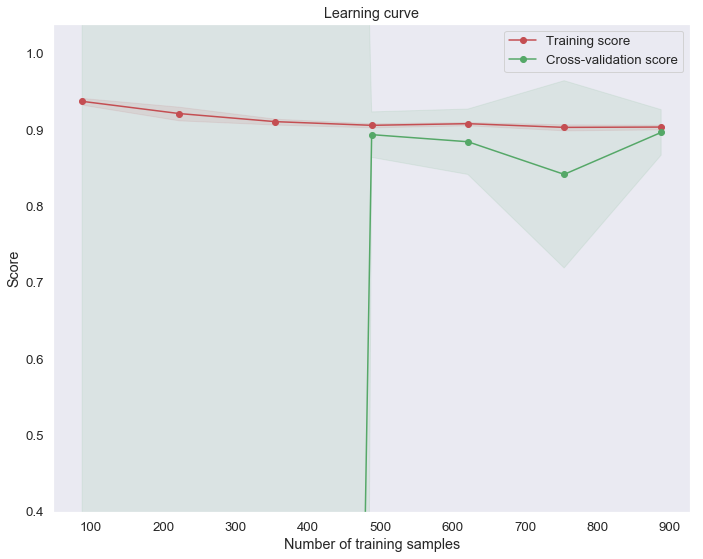

In [31]:
plt.figure(figsize=(10, 8))
plt.title('Learning curve')

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.grid()
plt.fill_between(
    train_sizes, train_scores_mean - train_scores_std,
    train_scores_mean + train_scores_std, alpha=0.1, color='r'
)
plt.fill_between(
    train_sizes, test_scores_mean - test_scores_std,
    test_scores_mean + test_scores_std, alpha=0.1, color='g'
)
plt.plot(
    train_sizes, train_scores_mean, 'o-', color='r',
    label='Training score'
)
plt.plot(
    train_sizes, test_scores_mean, 'o-', color='g',
    label='Cross-validation score'
)
plt.ylabel('Score')
plt.xlabel('Number of training samples')
plt.legend(loc='best')
plt.ylim(
    [np.min(train_scores) - 0.5, np.max(train_scores) + 0.1]
)
plt.tight_layout()

Mean CV train score:  0.8955628758816827
Mean CV test score:  0.8387230800114618


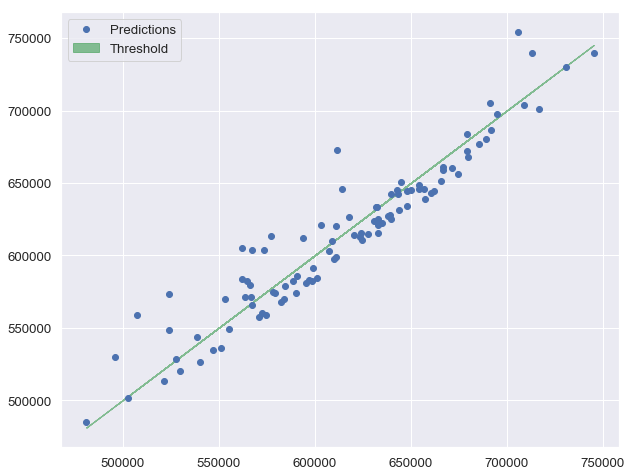

In [35]:
X_train, X_test, y_train, y_test = train_test_split(
    train, target, test_size=0.1, random_state=SEED
)
print('Mean CV train score: ', 
      np.mean(cross_val_score(model, X_train, y_train)))
print('Mean CV test score: ', 
      np.mean(cross_val_score(model, X_test, y_test)))

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

plt.figure(figsize=(10, 8))
plt.plot(y_test, y_pred, 'o', label='Predictions');
plt.fill_between(
    y_test[:, 0], y_test[:, 0] - THRESH, y_test[:, 0] + THRESH, 
    alpha=0.7, color='g', label='Threshold'
)
plt.legend(loc='best');